# Chapter 2: Taking Earth's Temperature

### Outline
1. [Long-term temperature evolution based on different data sources](#first-bullet)
2. [Recent temperature anomalies](#second-bullet)

### Section 1. Long-term temperature evolution in different data sets <a class="anchor" id="first-bullet"></a>

This tutorial walks you through analyzing and visualizing temperature data from the ERA5 reanalysis product reproducing main figures from the monthly <a href="https://climate.copernicus.eu/climate-bulletins">climate bulletins</a>.

#### Import libraries

In [1]:
# Python Standard Libraries
import os  
import datetime as dt
import zipfile
import urllib.request
from string import ascii_lowercase as ABC 

# Data Manipulation Libraries
import numpy as np 
import pandas as pd
import xarray as xr
import regionmask as rm

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates 
import cartopy.crs as ccrs 

plt.style.use('../copernicus.mplstyle')  # Set the visual style of the plots; not necessary for the tutorial

# Climate Data Store API for retrieving climate data
import cdsapi

#### Download temperature data from different sources

* Berkeley Earth (available in CDS as land-only)
* NOAA Global Temperature v5
* GISTEMP (available in CDS as globally averaged time series only)
* HadCRUT5
* ERA5


We will create dedicated folder for each data set

In [2]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({'berkeley': 'temperature_berkeley.nc'})  # is not available as netCDF, only as zip file
file_name.update({'gistemp': 'temperature_gistemp.gz'}) # is not available as netCDF, only as zip file
file_name.update({'hadcrut': 'temperature_hadcrut.nc'})
file_name.update({'era5': 'temperature_era5.nc'})

# Create the paths to the files
path_to = {source: os.path.join(f'data/{source}/', file) for source, file in file_name.items()}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(os.path.dirname(path), exist_ok=True) # create the folder if not available

path_to

{'berkeley': 'data/berkeley/temperature_berkeley.nc',
 'gistemp': 'data/gistemp/temperature_gistemp.gz',
 'hadcrut': 'data/hadcrut/temperature_hadcrut.nc',
 'era5': 'data/era5/temperature_era5.nc'}

##### NOAA GlobalTemp

Here we're going to access the data from NOAA using OPeNDAP. OPeNDAP is a protocol that allows for the remote access of scientific data stored in various formats over the internet. xarray is quite handy and allows to access data directly via OPENDAP. So retrieving data from NOAA basically becomes a one-liner:

In [3]:
url_to_noaa = 'https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v5/NOAAGlobalTemp_v5.0.0_gridded_s188001_e202212_c20230108T133308.nc'
noaa = xr.open_dataset(url_to_noaa)
noaa

<xarray.Dataset>
Dimensions:  (time: 1716, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2022-12-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P143Y0M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-01-08T18:33:09Z
    date_issued:                     2023-01-08T18:33:09Z

Let's remove the redundant z coordinate. Also note that we already have anomaliy data.

In [4]:
noaa = noaa['anom'].isel(z=0, drop=True)

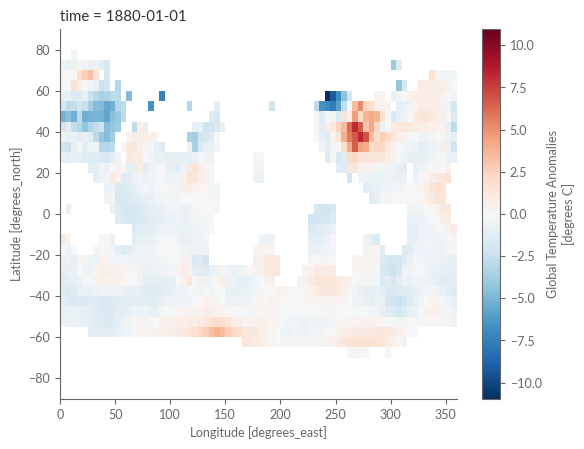

In [5]:
noaa.isel(time=0).plot()

##### Berkeley Earth
Next, we set up the directory where we will download and store our data.

NOTE: In the CDS, Berkeley Earth is only available over land. We need ocean as well, so let's take the data from the official provider:  https://berkeleyearth.org/data/ Global Montly Land - Ocean, 1x1 La-Lon Grid

The data is about 400 MB so depending on your downloading speed the process may take a while.

In [6]:
url_berkeley = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
urllib.request.urlretrieve(url_berkeley, path_to['berkeley'])


('data/berkeley/temperature_berkeley.nc',
 <http.client.HTTPMessage at 0x7f0c1c6bb070>)

In [6]:
berkeley = xr.open_dataset(path_to['berkeley'])
berkeley

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 2079, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.023e+03 2.023e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               20-Apr-2023 07:02:14
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Apr-2023 08:20:01
    ocean_source_history:  20-Apr-2023 05:22:16
    comment:               This file contains Berkeley Earth surface temperat...

It's not really common the report the time as floats, so let's convert it to datetime objects.

In [7]:
new_time_coords = xr.cftime_range(start='1850-01-01', periods=berkeley.time.size, freq='MS').to_datetimeindex()
berkeley.coords.update({'time': new_time_coords})


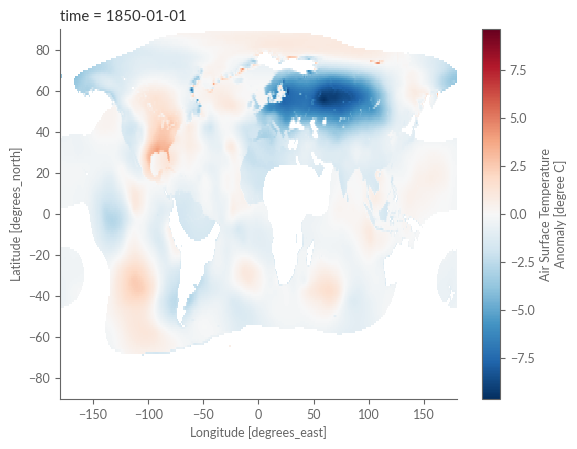

In [8]:
berkeley['temperature'].isel(time=0).plot()

NOTE: Berkeley recently rolled out a new machine learning augmented version providing a comprehensive, high-resolution instrumental temperature record back to 1750.

##### GISTEMP

We want the original gridded data (CDS only has time series), so head over to the NASA website: https://data.giss.nasa.gov/gistemp/
We download the [Land-Ocean Temperature Index, ERSSTv5, 1200km smoothing](https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz) in the following:

In [12]:
url_gistemp = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
urllib.request.urlretrieve(url_gistemp, path_to['gistemp'])

('data/gistemp/temperature_gistemp.gz',
 <http.client.HTTPMessage at 0x7f0b72977b80>)

In [9]:
with xr.open_dataset(path_to['gistemp']) as gistemp:
    gistemp = gistemp['tempanomaly']

gistemp

<xarray.DataArray 'tempanomaly' (time: 1721, lat: 90, lon: 180)>
[27880200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-05-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

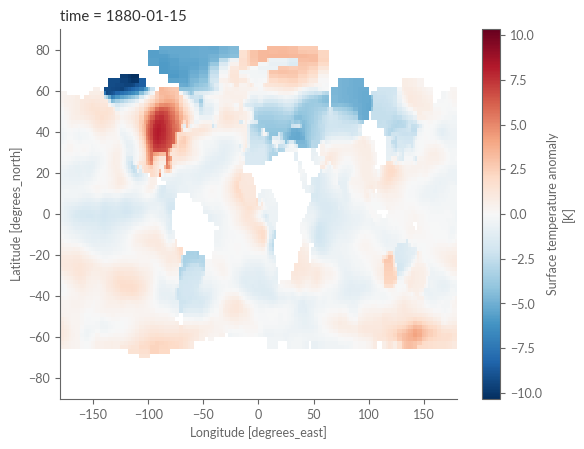

In [10]:
gistemp.isel(time=0).plot()

##### HadCRUT5

Now let's get the HadCRUT version 5 from the MetOffice. They also provide a separate file containing the weights that should be used to weigh the ocean and land grid cells. So we'll get that as well to follow their methodology.

In [11]:
url_hadcrut = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
url_hadcrut_weights = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.weights.nc'
urllib.request.urlretrieve(url_hadcrut, path_to['hadcrut'])
urllib.request.urlretrieve(url_hadcrut_weights, 'data/hadcrut/temperature_weights.nc')

('data/hadcrut/temperature_weights.nc',
 <http.client.HTTPMessage at 0x7f7cd9822170>)

In [12]:
with xr.open_dataset(path_to['hadcrut']) as hadcrut:
    hadcrut = hadcrut['tas_mean']

with xr.open_dataset('data/hadcrut/temperature_weights.nc') as hadcrut_weights:
    hadcrut_weights = hadcrut_weights['weights']
hadcrut

<xarray.DataArray 'tas_mean' (time: 2079, latitude: 36, longitude: 72)>
[5388768 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-03-16T12:...
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

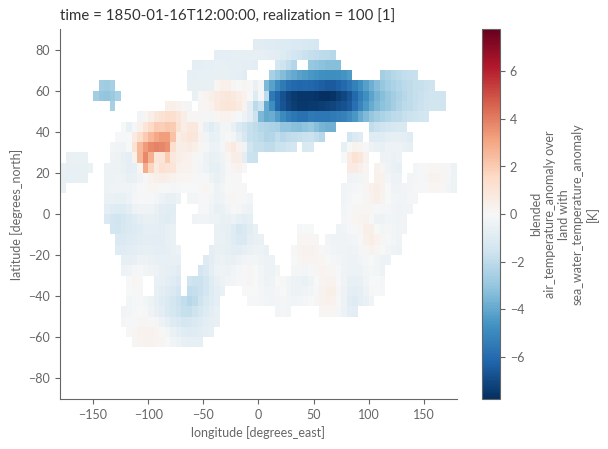

In [13]:
hadcrut.isel(time=0).plot()



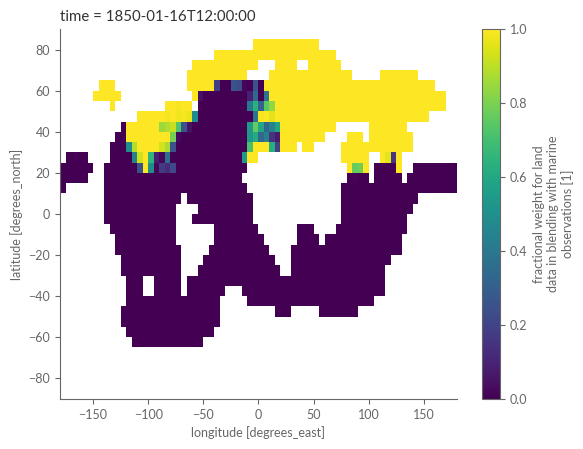

In [14]:
hadcrut_weights.isel(time=0).plot()


##### ERA5 reanalysis

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

In [ ]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': '2m_temperature',
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    'grid': [1, 1]
  },
  path_to['era5']
)

2023-07-04 09:36:33,022 INFO Welcome to the CDS
2023-07-04 09:36:33,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-04 09:36:33,325 INFO Request is queued
2023-07-04 09:36:34,385 INFO Request is running


Once downloaded, we can load this data into an `xarray.DataArray`.

In [15]:
with xr.open_dataarray(path_to['era5']) as era5:
  # convert from Kelvin to Celsius
  era5 -= 273.15 
  era5.attrs.update({'units': 'Celsius'})

era5

<xarray.DataArray 't2m' (time: 876, latitude: 181, longitude: 360)>
array([[[-31.649261, -31.649261, -31.649261, ..., -31.649261,
         -31.649261, -31.649261],
        [-30.952835, -30.9402  , -30.929382, ..., -30.972687,
         -30.963654, -30.958252],
        [-30.106659, -30.07959 , -30.052536, ..., -30.182434,
         -30.166199, -30.135529],
        ...,
        [-27.869446, -27.880264, -27.8947  , ..., -27.83516 ,
         -27.85141 , -27.858612],
        [-28.219467, -28.21405 , -28.210434, ..., -28.194199,
         -28.203217, -28.21225 ],
        [-28.831085, -28.831085, -28.831085, ..., -28.831085,
         -28.831085, -28.831085]],

       [[-33.26764 , -33.26764 , -33.26764 , ..., -33.26764 ,
         -33.26764 , -33.26764 ],
        [-32.241043, -32.237427, -32.233826, ..., -32.24826 ,
         -32.246445, -32.242844],
        [-31.14769 , -31.131454, -31.11882 , ..., -31.225266,
         -31.216248, -31.181961],
...
        [-37.745667, -37.78897 , -37.834076, ..., -37.66629 ,
         -37.70056 , -37.722214],
        [-38.039764, -38.052383, -38.063217, ..., -37.991043,
         -38.00728 , -38.02533 ],
        [-38.14621 , -38.14621 , -38.14621 , ..., -38.14621 ,
         -38.14621 , -38.14621 ]],

       [[-23.351715, -23.351715, -23.351715, ..., -23.351715,
         -23.351715, -23.351715],
        [-22.312485, -22.29625 , -22.280014, ..., -22.35759 ,
         -22.343155, -22.32872 ],
        [-20.70494 , -20.683289, -20.663437, ..., -20.766281,
         -20.748245, -20.726593],
        ...,
        [-27.88388 , -27.939804, -27.995743, ..., -27.764801,
         -27.80449 , -27.844193],
        [-28.342148, -28.358383, -28.372818, ..., -28.284409,
         -28.30246 , -28.322296],
        [-28.69757 , -28.69757 , -28.69757 , ..., -28.69757 ,
         -28.69757 , -28.69757 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
Attributes:
    units:      Celsius
    long_name:  2 metre temperature

Good to know: When dealing with temperature anomalies, the focus is on the change in temperature from a baseline or reference value, rather than the absolute temperature itself. This means we're interested in the difference or deviation from a reference point, which remains the same regardless of whether the temperature scale is Celsius, Kelvin, or Fahrenheit.

#### Streamline the different data sets

Let's streamline the different data sets such that they have the same variable and dimension names.

In [47]:
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

land_sea_mask = {
    'berkeley': berkeley['land_mask'],
    'hadcrut': hadcrut_weights,
    'era5': lsm.mask(era5),
    'noaa': lsm.mask(noaa),
    'gistemp': lsm.mask(gistemp)
}

In [16]:
berkeley = berkeley['temperature']
berkeley = berkeley.rename({'latitude': 'lat', 'longitude': 'lon'})
hadcrut = hadcrut.rename({'latitude': 'lat', 'longitude': 'lon'})
hadcrut_weights = hadcrut_weights.rename({'latitude': 'lat', 'longitude': 'lon'})
era5 = era5.rename({'latitude': 'lat', 'longitude': 'lon'})

noaa.name = 'noaa'
berkeley.name = 'berkeley'
gistemp.name = 'gistemp'
hadcrut.name = 'hadcrut'
era5.name = 'era5'

#### Limited spatial coverage in the past can lead to biases

Text(0.5, 1.0, '1950')

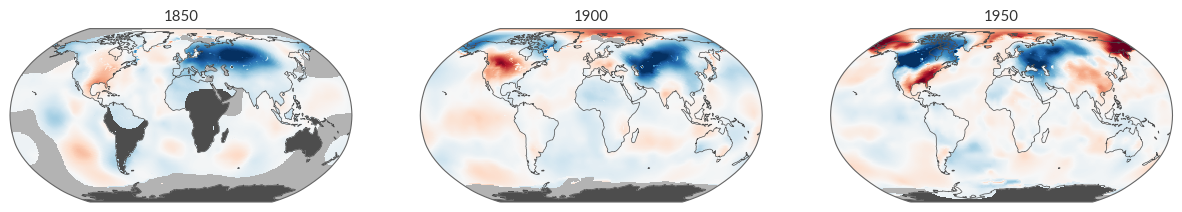

In [51]:
# Note that the farer back in time we go, the less of the globe is covered by the data illustrating the limited in-situ measurements available in the prior centuries.
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(15, 5))
ax = [plt.subplot(1, 3, i+1, projection=ccrs.Robinson()) for i in range(3)]
kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-8, vmax=8, add_colorbar=False)
berkeley.sel(time='1850-01').plot(ax=ax[0], **kwargs)
berkeley.sel(time='1900-01').plot(ax=ax[1], **kwargs)
berkeley.sel(time='1950-01').plot(ax=ax[2], **kwargs)
for a in ax:
    a.coastlines(lw=.5, color='.3')
    a.add_feature(cfeature.LAND, lw=.5, color='.3')
    a.add_feature(cfeature.OCEAN, lw=.5, color='.7')
    a.set_global()
    a.set_title('')
ax[0].set_title('1850', loc='center')
ax[1].set_title('1900', loc='center')
ax[2].set_title('1950', loc='center')

Note that at the beginning of the instrumental period, the temperature data has considerable gaps around the globe. This is due to the limited number of in-situ measurements available at that time. The coverage increases over time as more and more measurements become available. However, the reduced spatial coverage in the past, especially so in the Southern Hemisphere, can lead to biases which should be reflected in the associated uncertainties.

#### Comparing the data sets

First lets convert ERA5 from ansolute values to anomalies by subtracting the 1991-2020 climatology. 

In [18]:
ref_period = slice('1991', '2020')
era5_clim = era5.sel(time=ref_period).groupby('time.month').mean('time')
era5_anom = era5.groupby('time.month') - era5_clim

Now that we have all the data in the same format (time, lon, lat) and in anomalies, we can proceed with the analysis. Next step involves creating a mask for the regions of interest. We will use the regionmask package for this purpose. The package provides a number of predefined regions, but we will create our own mask for the Arctic region.

In [19]:
def weighted_spatial_average(da, weights=None):
    """Calculate the weighted spatial average of a DataArray.
    
    Parameters
    ----------
    da : xarray.DataArray
        The DataArray to average.
    weights : xarray.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
        If not provided, the area of each grid cell will be used.
    """
    if weights is None:
        # Calculate the area of each grid cell
        weights = np.cos(np.deg2rad(da.lat))
    
    return da.weighted(weights).mean(('lat', 'lon'))

In [52]:

a = weighted_spatial_average(hadcrut)
b = weighted_spatial_average(berkeley)
c = weighted_spatial_average(gistemp)
d = weighted_spatial_average(noaa)
e = weighted_spatial_average(era5_anom)


In [53]:
a -= a.sel(time=ref_period).mean('time')
b -= b.sel(time=ref_period).mean('time')
c -= c.sel(time=ref_period).mean('time')
d -= d.sel(time=ref_period).mean('time')
e -= e.sel(time=ref_period).mean('time')


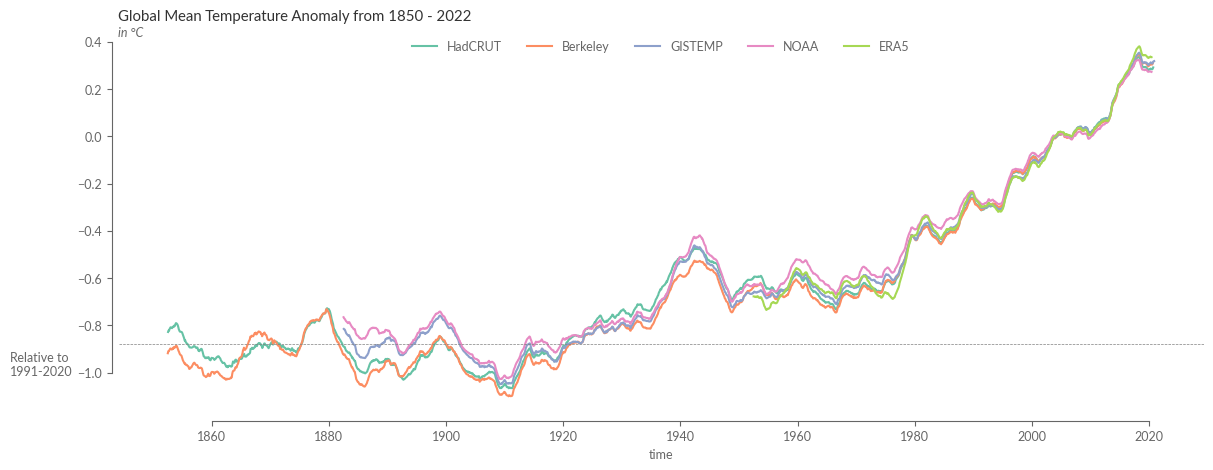

In [81]:
import seaborn as sns

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
# ax2 = ax.twinx()
a.rolling(time=61, center=True).mean().plot(ax=ax, label='HadCRUT')
b.rolling(time=61, center=True).mean().plot(ax=ax, label='Berkeley')
c.rolling(time=61, center=True).mean().plot(ax=ax, label='GISTEMP')
d.rolling(time=61, center=True).mean().plot(ax=ax, label='NOAA')
e.rolling(time=61, center=True).mean().plot(ax=ax, label='ERA5')
plt.legend(ncols=6, frameon=False, loc='upper center')
sns.despine(ax=ax, trim=True, offset=5)
# sns.despine(ax=ax2, trim=True, offset=5, left=True, right=False)
ax.xaxis.set_major_locator(mdates.YearLocator(20))
# ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Global Mean Temperature Anomaly from 1850 - 2022')
ax.text(.0, .98, 'in °C', transform=ax.transAxes, style='italic')
ax.text(-.1, .1, 'Relative to \n1991-2020', rotation=0, ha='left', transform=ax.transAxes)
ax.axhline(-.88, color='.5', lw=.5, ls='--')

In [80]:
ref_level_1850 = xr.concat([a, b, c, d, e], dim='source').sel(time=slice('1850', '1900')).mean()
print(ref_level_1850)

<xarray.DataArray 'hadcrut' ()>
array(-0.88805437)
Coordinates:
    realization  int64 100


Taking Earth's temperature... using ERA5

In [124]:
# mean temperature in the reference period
mean_temp_ref_period = era5.sel(time=ref_period).weighted(np.cos(np.deg2rad(era5_anom.coords['latitude']))).mean(('longitude', 'latitude')).mean()
print(f'The mean temperature in the reference period is {mean_temp_ref_period.values:.1f} °C.')

The mean temperature in the reference period is 14.4 °C.


## Visualising recent temperature anomalies

We calculate the climatology, i.e., the mean over a specific period, and anomalies (deviations from this mean). Here we use the time period 1991-2020 as a reference period in accordance with [current standards](https://climate.copernicus.eu/new-decade-brings-reference-period-change-climate-data). However, you may want to use the historical base period of 1961-1990 if you are particular interested in assessing changes due to climate change.

In [11]:
reference_period = slice('1991', '2020')
climatology = t2m.sel(time=reference_period).groupby('time.month').mean()
anomalies = t2m.groupby('time.month') - climatology

Next, we select a month of interest (`moi`) - let's go with March 2022.

In [14]:
moi = 3  # March (1 = January, 2 = February, etc.)

number2month = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

Plotting our data is a great way to visualize the temperature anomalies. We'll create maps showing the anomalies in three different regions: globally, Europe and the Arctic.

To start, three different types of map projections are specified, each for the corresponding region. The `EqualEarth()` projection is used for the global view, while `NearsidePerspective()` is used for the European and Arctic views. The central longitude and latitude are adjusted according to the region in focus. These projections help in providing an accurate spatial representation of the temperature anomalies.

In [15]:
SUBTITLES = ['Global', 'Europe', 'Arctic']
proj_maps = [
  ccrs.EqualEarth(),  # Global
  ccrs.NearsidePerspective(central_longitude=10, central_latitude=50),  # Europe
  ccrs.NearsidePerspective(central_longitude=0, central_latitude=90)  # Artic
]
proj_data = ccrs.PlateCarree()  # projection for the data

Next, a color normalization is established with the `Normalize()` function, which sets the range of temperature anomalies from -6 to 6. This ensures a consistent scale for interpreting the temperature anomaly maps across all three regions.

In [16]:
norm = mcolors.Normalize(vmin=-6, vmax=6)

Finally, we create a figure with three subplots dedicated for the three regions (`axes`), an axis for the colorbar (`cax`) and another for the title/subtitle (`tax`).

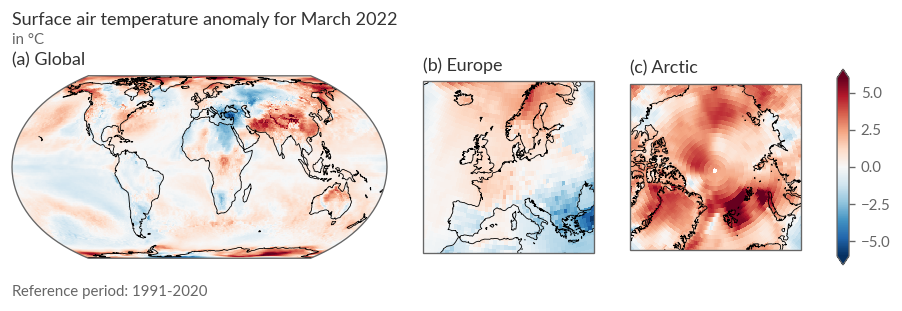

In [37]:
time = '2022-{0:02d}-01'.format(moi)

# Create the figure
fig = plt.figure(figsize=(9, 2.5), dpi=120)
gs = GridSpec(3, 4, figure=fig, width_ratios=[2.2, 1, 1, 0.07], height_ratios=[.05, 1, .05])

# Add the axes
tax = fig.add_subplot(gs[0, 0])
bax = fig.add_subplot(gs[2, 0])
axes = [fig.add_subplot(gs[1, i], projection=proj_maps[i]) for i in range(3)]
cax = fig.add_subplot(gs[1, 3])

# Set the extent of the maps
axes[1].set_extent([-15, 30, 33, 70], crs=proj_data)
axes[2].set_extent([-180, 180, 70, 90], crs=proj_data)

# Add coastlines and anomlies
for ax in axes:
  ax.coastlines(lw=0.5)
  anomalies.sel(time=time, drop=True).plot(
    ax=ax, transform=proj_data, cbar_ax=cax, norm=norm,
    cbar_kwargs=dict(label='')
  )

# Add titles, labels and text
for i, ax in enumerate(axes):
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')

title = f'Surface air temperature anomaly for {number2month[moi]} 2022'
tax.set_title(title)
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.axis('off')
bax.axis('off')
ref_start = reference_period.start
ref_end = reference_period.stop
bax.text(0, 0, f'Reference period: {ref_start}-{ref_end}', ha='left', va='bottom', transform=bax.transAxes)
fig.subplots_adjust(bottom=.0, hspace=0.02)
plt.show()

## Temperature anomalies over the last 70 years

To analyze long-term trends, we examine the weighted mean temperature anomalies over the past 70 years globally, in Europe and the Arctic regions.

The first step is to define the subregions we're interested in (Europe and the Arctic)

In [38]:
regions = {
    'europe': {'longitude': slice(-15, 30), 'latitude': slice(70, 30)},
    'arctic': {'longitude': slice(None, None), 'latitude': slice(None, 70)},
}

The second step is to to compute weights as the cosine of the latitude. These weights account for the spherical geometry of the Earth in our calculations. Since the Earth's surface area is greater at the equator than at the poles, the data points representing temperatures from different latitudes aren't equivalent. Weighting by the cosine of the latitude provides a way to adjust for this effect and treat the data more accurately.

In [39]:
weights = np.cos(np.deg2rad(t2m.latitude))
weights.name = 'weights'

We calculate the weighted mean temperature anomalies for each of our regions of interest. Each of these series of mean anomalies is smoothed using a rolling mean with a window size of 12 months to remove short-term fluctuations and highlight longer-term trends.

In [40]:
anom_mean_global = anomalies.weighted(weights).mean(('latitude', 'longitude'))
anom_mean_europe = anomalies.sel(regions['europe']).weighted(weights).mean(('latitude', 'longitude'))
anom_mean_arctic = anomalies.sel(regions['arctic']).weighted(weights).mean(('latitude', 'longitude'))

anom_mean_global = anom_mean_global.rolling(time=12, center=True).mean()
anom_mean_europe = anom_mean_europe.rolling(time=12, center=True).mean()
anom_mean_arctic = anom_mean_arctic.rolling(time=12, center=True).mean()

In addtion, let's have a look at the mean anomalies for a our month of interest (March) across years. Using the `sel` function, we extract data for the specific month from each of the rolling mean anomaly time series.

In [41]:
is_moi = anom_mean_global.time.dt.month == moi

anom_mean_moi_global = anom_mean_global.sel(time=is_moi)
anom_mean_moi_europe = anom_mean_europe.sel(time=is_moi)
anom_mean_moi_arctic = anom_mean_arctic.sel(time=is_moi)

And finally, let's visualize these long-term trends. We want to produce a bar plot with positive anomalies colored in red and negative anomalies colored in blue.

In [42]:
clrs_cool_warm = sns.color_palette('RdBu_r', as_cmap=False)
blue, red = clrs_cool_warm[0], clrs_cool_warm[-1]

colors_global = [red if anom >=0 else blue for anom in anom_mean_global]
colors_europe = [red if anom >=0 else blue for anom in anom_mean_europe]
colors_arctic = [red if anom >=0 else blue for anom in anom_mean_arctic]

We must take care of the proper bar width ourselves which depends on the number of days within a given month.

In [43]:
bar_width = pd.to_datetime(anom_mean_global.time.values).days_in_month
bar_width = [dt.timedelta(days=i) for i in bar_width]
bar_width_moi = dt.timedelta(days=31) 

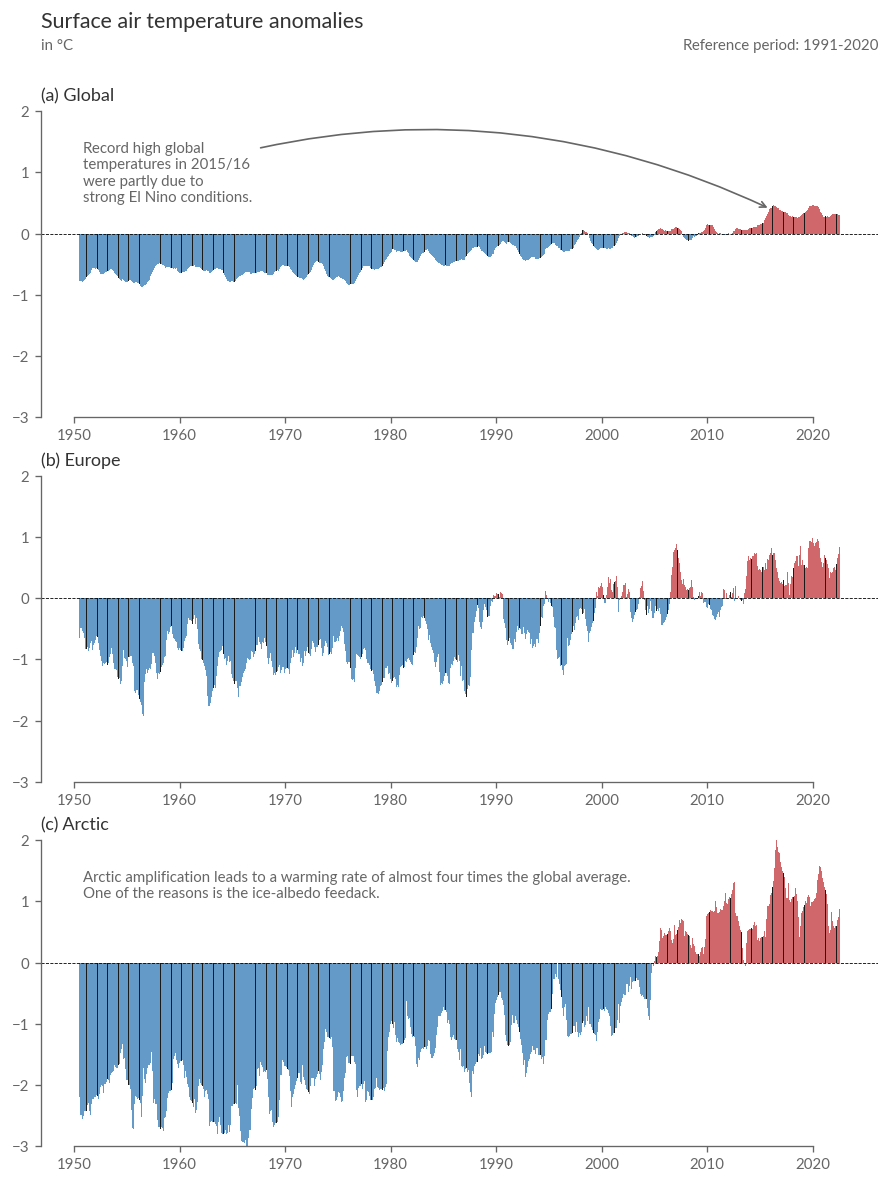

In [49]:
fig = plt.figure(figsize=(9, 12), dpi=120)
gs = GridSpec(4, 1, figure=fig, height_ratios=[.05, 1, 1, 1], hspace=0.25)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 4)]

axes[0].bar(pd.to_datetime(anom_mean_global.time), anom_mean_global.values, width=bar_width, color=colors_global, alpha=.75, align='edge')
axes[1].bar(pd.to_datetime(anom_mean_europe.time), anom_mean_europe.values, width=bar_width, color=colors_europe, alpha=.75, align='edge')
axes[2].bar(pd.to_datetime(anom_mean_arctic.time), anom_mean_arctic.values, width=bar_width, color=colors_arctic, alpha=.75, align='edge')

axes[0].bar(pd.to_datetime(anom_mean_moi_global.time), anom_mean_moi_global.values, width=bar_width_moi, color='.1', align='edge')
axes[1].bar(pd.to_datetime(anom_mean_moi_europe.time), anom_mean_moi_europe.values, width=bar_width_moi, color='.1', align='edge')
axes[2].bar(pd.to_datetime(anom_mean_moi_arctic.time), anom_mean_moi_arctic.values, width=bar_width_moi, color='.1', align='edge')

# Add annotations describing the data
desc_global = 'Record high global \ntemperatures in 2015/16 \nwere partly due to \nstrong El Nino conditions.'
desc_artic = 'Arctic amplification leads to a warming rate of almost four times the global average.\nOne of the reasons is the ice-albedo feedack.'
axes[0].annotate(
  desc_global,
  xy=(dt.datetime(2016, 1, 1), 0.4),
  xytext=(0.05, 0.9),
  textcoords=axes[0].transAxes,
  ha='left', va='top',
  arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
)
axes[2].text(0.05, 0.9, desc_artic, transform=axes[2].transAxes, ha='left', va='top')


for i, ax in enumerate(axes):
  ax.set_ylim(-3, 2)
  ax.axhline(0, color='k', ls='--', lw=0.5)
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
tax.axis('off')
tax.set_title('Surface air temperature anomalies', fontsize='x-large')
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.text(1, 0, f'Reference period: {ref_start}-{ref_end}', ha='right', va='bottom', transform=tax.transAxes)

sns.despine(fig, trim=True)

In conclusion, by analyzing and visualizing this temperature data, we can see the stark reality of rising temperatures - an irrefutable indicator of global warming.

### References

[1] Rantanen, M., Karpechko, A.Y., Lipponen, A. et al. The Arctic has warmed nearly four times faster than the globe since 1979. Commun Earth Environ 3, 168 (2022). https://doi.org/10.1038/s43247-022-00498-3